## CSC2611 - Lab (including Exercise)
#### Aniket Kali

The portion of this notebook under "Exercise" can safely be ignored. It is included as certain portions of the "Lab" rely on results from it.

You can find the GitHub repository associated to this notebook here: 

In [1]:
import pickle
from collections import Counter

import numpy as np
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.util import ngrams
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.spatial import distance
from scipy import stats
from gensim.models import KeyedVectors

import seaborn as sns
sns.set_style("darkgrid")

In [2]:
RG65 = [
    ('cord', 'smile', 0.02),
    ('rooster', 'voyage', 0.04),
    ('noon', 'string', 0.04),
    ('fruit', 'furnace', 0.05),
    ('autograph', 'shore', 0.06),
    ('automobile', 'wizard', 0.11),
    ('mound', 'stove', 0.14),
    ('grin', 'implement', 0.18),
    ('asylum', 'fruit', 0.19),
    ('asylum', 'monk', 0.39),
    ('graveyard', 'madhouse', 0.42),
    ('glass', 'magician', 0.44),
    ('boy', 'rooster', 0.44),
    ('cushion', 'jewel' , 0.45),
    ('monk', 'slave', 0.57),
    ('asylum', 'cemetery', 0.79),
    ('coast', 'forest', 0.85),
    ('grin', 'land', 0.88),
    ('shore', 'woodland', 0.90),
    ('monk', 'oracle', 0.91),
    ('boy', 'sage', 0.96),
    ('automobile', 'cushion', 0.97),
    ('mound', 'shore', 0.97),
    ('lad', 'wizard', 0.99),
    ('forest', 'graveyard', 1.00),
    ('food', 'rooster', 1.09),
    ('cemetery', 'woodland', 1.18),
    ('shore', 'voyage', 1.22),
    ('bird', 'woodland', 1.24),
    ('coast', 'hill', 1.26),
    ('furnace', 'implement', 1.37),
    ('crane', 'rooster', 1.41),
    ('hill', 'woodland', 1.48),
    ('car', 'journey', 1.55),
    ('cemetery', 'mound', 1.69),
    ('glass', 'jewel', 1.78),
    ('magician', 'oracle', 1.82),
    ('crane', 'implement', 2.37),
    ('brother', 'lad', 2.41),
    ('sage', 'wizard', 2.46),
    ('oracle', 'sage', 2.61),
    ('bird', 'crane', 2.63),
    ('food', 'fruit', 2.69),
    ('brother', 'monk', 2.74),
    ('asylum', 'madhouse', 3.04),
    ('furnace', 'stove', 3.11),
    ('magician', 'wizard', 3.21),
    ('hill', 'mound', 3.29),
    ('cord', 'string', 3.41),
    ('glass', 'tumbler', 3.45),
    ('grin', 'smile', 3.46),
    ('serf', 'slave', 3.46),
    ('journey', 'voyage', 3.58),
    ('autograph', 'signature', 3.59),
    ('coast', 'shore', 3.60),
    ('forest', 'woodland', 3.65),
    ('implement', 'tool', 3.66),
    ('cock', 'rooster', 3.68),
    ('boy', 'lad', 3.82),
    ('cushion', 'pillow', 3.84),
    ('cemetery', 'graveyard', 3.88),
    ('automobile', 'car', 3.92),
    ('midday', 'noon', 3.94),
    ('gem', 'jewel', 3.94)
]

## Exercise
### Meaning construction from text

#### Step 2

In [3]:
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to /home/aniket/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [4]:
words = [w.lower() for w in brown.words() if w.isalpha()]
words_counter = Counter(words)
W_5000 = [w_f[0] for w_f in words_counter.most_common(5000)]

In [5]:
len(words)

981716

In [6]:
words_rg65 = list(set([item[0] for item in RG65] + [item[1] for item in RG65]))
W = W_5000 + [w for w in words_rg65 if w not in W_5000]
W_len = len(W)

W_len

5030

In [7]:
# Top and bottom 5 words
print(W_5000[:5])
print(W_5000[-5:])

['the', 'of', 'and', 'to', 'a']
['vertex', 'rourke', 'killpath', 'haney', 'letch']


#### Step 3

In [8]:
bigrams = list(ngrams(words, 2))
bigrams_counter = Counter(bigrams)

In [10]:
M1 = np.zeros((W_len, W_len))
for i in tqdm(range(W_len)):
    for j in range(W_len):
        word_i, word_j = W[i], W[j]
        M1[i][j] = bigrams_counter[(word_i, word_j)]

M1

100%|██████████| 5030/5030 [00:19<00:00, 264.19it/s]


array([[3.600e+01, 6.500e+01, 6.800e+01, ..., 4.000e+00, 4.000e+00,
        0.000e+00],
       [9.774e+03, 1.000e+01, 8.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.307e+03, 1.340e+02, 3.800e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.000e+00, 2.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 2.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

#### Step 4

In [11]:
# https://en.wikipedia.org/wiki/Pointwise_mutual_information#Definition
# pmi(x;y) = log2(P(x,y) / P(x)P(y)) = log2(P(x|y) / P(x)) 

In [12]:
X_total, Y_total, M1_total = M1.sum(axis=1), M1.sum(axis=0), M1.sum()

In [13]:
P_x_y_joint = M1 / M1_total  # Joint distn of X, Y

P_x = X_total / M1_total  # Marginal distn of X
P_y = Y_total / M1_total  # Marginal distn of Y
P_x_y_ind = np.array([P_x]).T @ np.array([P_y])

# Take the per-element product of the matching indicies of the marginal distn vectors
# Take the log2, then set null/negatives to 0

MI_ratio = np.divide(P_x_y_joint, P_x_y_ind, where=(P_x_y_ind!=0))
PMI = np.log2(MI_ratio, where=(MI_ratio!=0))
M1_P = np.maximum(0, PMI)

#### Step 5

In [15]:
M2_10 = PCA(n_components=10).fit_transform(M1_P)
M2_100 = PCA(n_components=100).fit_transform(M1_P)
M2_300 = PCA(n_components=300).fit_transform(M1_P)

#### Step 6

In [16]:
P, S = [], []  # These are matched by their index, in the same order
for rg1, rg2, sim_val in RG65:
    if (rg1 in W) and (rg2 in W):
        P.append((rg1, rg2))
        S.append(sim_val)

#### Step 7

In [17]:
def get_cos_sims(mat, W, P):
    sims = []
    for w1, w2 in P:
        i1, i2 = W.index(w1), W.index(w2)
        v1, v2 = mat[i1], mat[i2]
        cos_sim = cosine_similarity([v1], [v2])[0][0]
        sims.append(cos_sim)
    return sims

In [18]:
S_from_mats = {
    "S_M1": get_cos_sims(M1, W, P),
    "S_M1_P": get_cos_sims(M1_P, W, P),
    "S_M2_10": get_cos_sims(M2_10, W, P),
    "S_M2_100": get_cos_sims(M2_100, W, P),
    "S_M2_300": get_cos_sims(M2_300, W, P)
}

#### Step 8 

In [19]:
for S_name in S_from_mats:
    cur_S = S_from_mats[S_name]
    pearson = stats.pearsonr(S, cur_S)[0]
    print(f'{S_name}: {pearson}')

S_M1: 0.19061706861411143
S_M1_P: 0.16022361100264837
S_M2_10: 0.16433419360266788
S_M2_100: 0.3694616901678858
S_M2_300: 0.3916307757051189


## Lab -- Part 1
### Synchronic word embedding

#### Step 2

In [20]:
word2vec_model = KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin.gz',
    binary=True
)

In [21]:
word2vec_embed_pairs = []
for w1, w2 in P:
    w1_embed = word2vec_model[w1].reshape(1, -1)
    w2_embed = word2vec_model[w2].reshape(1, -1)
    word2vec_embed_pairs.append((w1_embed, w2_embed))

#### Step 3

In [22]:
cos_sims = []
for w1_embed, w2_embed in word2vec_embed_pairs:
    cos_sim = cosine_similarity(w1_embed, w2_embed)[0][0]
    cos_sims.append(cos_sim)

In [23]:
pearson_score = stats.pearsonr(S, cos_sims)[0]
print(f'word2vec: {pearson_score}') 

word2vec: 0.7748062479625776


The correlation between word2vec and the human similiarities is markedly higher than that of the PPMI matrix and its PCA-based derivatives, so much so that word2vec actually approaches human ratings whereas the other method isn't even close. 

Mikolov et al. (2013) outlines the methods for word2vec, and consequently we can infer several potential reasons for the better performance that may inform the general development of word embeddings. First, and most simple, is that word2vec relies on much more training data (6B tokens) compared to us (1M tokens), which permits more context in line with the distributional hypothesis. Data alone does not make a method better however. In our method, we utilized two techniques (PPMI and PCA) to tune for relevant information for word representations. Mikolov et al. (2013) introduces several methods to refine the input in key ways, including skip grams, negative sampling, and neural network training. These are costlier (as is computing on more data), but with thorough justification clearly can also result in more accurate word embeddings.

#### Step 4 - Setup

In [24]:
SEM_ANALOGIES = 'semantic_analogies.txt'
SYN_ANALOGIES = 'syntactic_analogies.txt'
SEM_FILTERED = 'semantic_filtered.txt'
SYN_FILTERED = 'syntactic_filtered.txt'

In [25]:
def filter_analogies(f_name_in, f_name_out):
    rows = []
    
    with open(f_name_in, 'r') as f_in:
        for line in f_in:
            if ':' in line:
                rows.append(line)
            analogy_words = line.split()
            if all(w.lower() in W for w in analogy_words):
                new_line = " ".join(analogy_words)
                rows.append(new_line)
    
    with open(f_name_out, 'w') as f_out:
        for row in rows:
            f_out.write(f'{row}\n')

In [26]:
filter_analogies(SEM_ANALOGIES, SEM_FILTERED)
filter_analogies(SYN_ANALOGIES, SYN_FILTERED)

In [27]:
lsa_model = KeyedVectors(300)
lsa_model.add_vectors(W, M2_300)

#### Step 4 - Analysis

In [28]:
analogy_scores = {
    "sem_word2vec": word2vec_model.evaluate_word_analogies(SEM_FILTERED),
    "syn_word2vec": word2vec_model.evaluate_word_analogies(SYN_FILTERED),
    "sem_lsa": lsa_model.evaluate_word_analogies(SEM_FILTERED),
    "syn_lsa": lsa_model.evaluate_word_analogies(SYN_FILTERED)
}

In [29]:
for analogy_type in analogy_scores:
    score = analogy_scores[analogy_type][0]
    print(f'{analogy_type}: {score}')

sem_word2vec: 0.88
syn_word2vec: 0.6859308384651823
sem_lsa: 0.13142857142857142
syn_lsa: 0.07816200852676457


The LSA model performs far worse and is generally unable to predict the analogy with much accuracy at all, whereas the word2vec model succeeds in predicting the accuracy much of the time -- even with us controlling for both models operating on the same subset of data. This is consistent with previous comments above, about the general correlation of our own methods versus word2vec to human similarities. Once again, we likely suffer from less data and less sophistication in our model

#### Step 5

One general shortcoming in both the LSA and word2vec model is their fixed nature and how this inhibits a more robust word representation. The most basic point in this regard is the inability to realize polysemy: the same word may have multiple meanings, sometimes rather distinct, which are collapsed into a single word embedding. This may be a particularly noticeable problem when a more distinct sense of a word is less common (but nonetheless present). Consider the example of "mouse": its "rodent" sense may be less common than its "device" sense, leading its word embedding to lean more to the "device" sense. Similarity evaluations would therefore fare more poorly when trying to compare to the "rodent" sense of "mouse". 

One method to improve this would be by constructing individual contextual usage embeddings using BERT (Devlin et al. 2018). Usage embeddings are fine-tuned to the individual context of words, and therefore more sensitive to the different possible meanings of a word. Given a set of usage embeddings, we can classify them by various means, including dictionary definitions (Hu et al. 2019) or classic clustering techniques (Giulianelli et al. 2020). This approach would provide us with multiple representations of a word, constructed from differences in the context that are manifested by whether they belong to this sense or that sense. These in turn allow us to make more precise similarity judgements between various word (really sense) vectors, and account for non-dominant senses. 
similarity judgements, particularly to less dominant senses. 

## Lab -- Part 2
### Diachronic word embedding

Part 1

In [30]:
with open('embeddings/data.pkl', 'rb') as in_f:
    data = pickle.load(in_f)

words = data['w']
    
word_mat = np.asarray(data['E'])  # (2000, 10, 300)
decade_mat = np.transpose(data['E'], axes=[1,0,2])  # (10, 2000, 300)

# The file is a dictionary that contains the following entries:
# 'w': a list of 2000 words, a subset of the English lexicon
# 'd': a list of decades between 1900 and 2000
# 'E': a 2000 by 10 by 300 list of list of vectors; the (i,j)-th entry is a 300-dimensional vector for the i-th word in the j-th decade

#### Part 2 - Semantic change in individual words

Method 1 - Maximum Cosine Distance

Cosine distance is a well-known method of evaluating the difference between word embedding vectors, as it ignores the geometric length of vectors. 

We can run a simple evaluation of the cosine distance between the initial embedding, and the embedding at every other timestamp t, of a word, and report the maximum. Namely, for a word embedding vector, e_t, compute the cosine difference between e_0 and e_t (t=1...9), then report the maximum. 

In [95]:
max_cos_dists = {}

for i in tqdm(range(2000)):
    cur_word = words[i]
    init_embed = word_mat[i][0]
    
    max_dist = 0
    for d in range(1, 10):
        cur_embed = word_mat[i][d]
        cur_dist = distance.cosine(init_embed, cur_embed)
        if cur_dist > max_dist:
            max_dist = cur_dist
    
    max_cos_dists[cur_word] = round(max_dist, 4)

100%|██████████| 2000/2000 [00:00<00:00, 4410.34it/s]


In [96]:
max_cos_dists_records = list(max_cos_dists.items())
max_cos_dists_records.sort(key=lambda x:x[1])

In [97]:
max_cos_dists_records[:20]  # Least changing words (lowest distance)

[('techniques', 0),
 ('skills', 0),
 ('mcgraw', 0),
 ('ml', 0),
 ('april', 0.2392),
 ('november', 0.2826),
 ('february', 0.295),
 ('october', 0.2971),
 ('january', 0.3018),
 ('increase', 0.3037),
 ('months', 0.3097),
 ('june', 0.3118),
 ('december', 0.3137),
 ('september', 0.3179),
 ('century', 0.318),
 ('daughter', 0.3201),
 ('evening', 0.3219),
 ('payment', 0.3227),
 ('feet', 0.3233),
 ('miles', 0.3257)]

In [98]:
max_cos_dists_records[-20:]  # Most changing words (highest distance)

[('stanford', 0.7675),
 ('film', 0.7759),
 ('therapy', 0.776),
 ('shift', 0.7769),
 ('assessment', 0.7785),
 ('princeton', 0.7827),
 ('berkeley', 0.7866),
 ('patterns', 0.8111),
 ('media', 0.8125),
 ('shri', 0.8244),
 ('van', 0.8367),
 ('approach', 0.8399),
 ('impact', 0.848),
 ('perspective', 0.8557),
 ('goals', 0.8595),
 ('sector', 0.92),
 ('radio', 0.9339),
 ('programs', 0.9908),
 ('computer', 0.9963),
 ('objectives', 0.9985)]

Method 2 - k-Means Cluster Shifts

In a coarse way, words can be thought of as existing in broad semantic categories. These semantic categories can change over time, and the extent to which they change, and the words within them relatively rank their fellow categories members, is a possible measure of change.

Specifically, for each time t=0...9, use k-Means to produce a set of k=50 clusters. Measure the average cosine distance of a word to its fellow category members at time 0. Then, for t=1...9, repeat the same measurement. Take the difference between the distance at t=0 and t=1...9, and report the maximum distance as the change for a word

In [36]:
decade_kmeans = []
for i in tqdm(range(10)):
    decade_kmeans.append(KMeans(n_clusters=50).fit(decade_mat[i]))

100%|██████████| 10/10 [02:16<00:00, 13.62s/it]


In [37]:
cluster_idxs = {}  # word --> [[idxs of fellow cluster members], ...per decade]
for d in tqdm(range(10)):
    cur_clusters = decade_kmeans[d].labels_
    for i in range(2000):
        cur_word = words[i]
        cur_cluster_idx = cur_clusters[i]
        fellow_idxs = []
        
        for j in range(2000):
            if i == j:
                continue
            if cur_clusters[j] == cur_cluster_idx:
                fellow_idxs.append(j)
        
        if cur_word not in cluster_idxs:
            cluster_idxs[cur_word] = []
        cluster_idxs[cur_word].append(fellow_idxs)

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


In [40]:
cluster_dists = {}  # word --> [avg cos dist to fellow cluster members, ...per decade]
for i in tqdm(range(2000)):
    cur_word = words[i]
    cluster_dists[cur_word] = []
    for d in range(10):
        fellow_idxs = cluster_idxs[cur_word][d]
        dists = []
        
        for idx in fellow_idxs:
            word_embed = word_mat[i][d]
            fellow_embed = word_mat[idx][d]
            dist = distance.cosine(word_embed, fellow_embed)
            
            if np.isnan(dist):
                continue
            
            dists.append(dist)
        
        cluster_dists[cur_word].append(np.mean(dists))

100%|██████████| 2000/2000 [00:22<00:00, 88.64it/s]


In [41]:
max_kmeans_diff = {}  # word --> max kmeans diff
for i in tqdm(range(2000)):
    cur_word = words[i]
    cur_word_dists = cluster_dists[cur_word]
    init_word_dist = cur_word_dists[0]
    
    max_diff = 0
    for j in range(1, 10):
        cur_word_dist = cur_word_dists[j]
        cur_diff = np.abs(cur_word_dist - init_word_dist)
        if cur_diff > max_diff:
            max_diff = cur_diff
    
    max_kmeans_diff[cur_word] = round(max_diff, 4)

100%|██████████| 2000/2000 [00:00<00:00, 61750.41it/s]


In [42]:
max_kmeans_diff_records = list(max_kmeans_diff.items())
max_kmeans_diff_records.sort(key=lambda x:x[1])

In [43]:
max_kmeans_diff_records[:20]  # Least changing words (lowest distance)

[('techniques', 0),
 ('skills', 0),
 ('mcgraw', 0),
 ('ml', 0),
 ('favor', 0.0186),
 ('territory', 0.0194),
 ('assumption', 0.0198),
 ('product', 0.0199),
 ('publication', 0.0221),
 ('weakness', 0.0223),
 ('source', 0.0227),
 ('association', 0.0229),
 ('collection', 0.023),
 ('strike', 0.025),
 ('administration', 0.0257),
 ('heads', 0.0259),
 ('adjustment', 0.0261),
 ('order', 0.0262),
 ('location', 0.0262),
 ('clothes', 0.0264)]

In [44]:
max_kmeans_diff_records[-20:]  # Most changing words (highest distance)

[('september', 0.214),
 ('words', 0.2156),
 ('october', 0.217),
 ('formula', 0.2191),
 ('equation', 0.2207),
 ('alcohol', 0.2228),
 ('b', 0.2233),
 ('press', 0.2239),
 ('witness', 0.2259),
 ('e', 0.2276),
 ('winter', 0.236),
 ('f', 0.236),
 ('p', 0.2374),
 ('k', 0.2383),
 ('g', 0.2402),
 ('month', 0.2418),
 ('paris', 0.2434),
 ('moscow', 0.245),
 ('year', 0.2532),
 ('h', 0.256)]

Method 3 - k-NN Relative Change

Words change not only with respect to themselves, but can move around in semantic space. One method of evaluating this is by observing how much words change with respect to their original neighbourhood. 

Given a word embedding vector at time 0, e_0, obtain its k=10 nearest neighbours. Compute the average cosine similarity from e_0 to its 10NN. Then, for e_1 through e_9, compute the average cosine similarity from e_i to each of its original 10NN at time 0. Take the difference between the average cosine similarity at time 0 and each time i, and report the maximum as the amount of change for a word.

In [67]:
for d in range(10):
    zero_words = []
    for w in range(2000):
        if np.sum(decade_mat[d][w]) == 0:
            zero_words.append(w)
    print(d, zero_words)

0 []
1 [1251, 1312, 1668, 1687, 1777]
2 [1251]
3 [1251, 1687]
4 [1687]
5 []
6 []
7 []
8 []
9 []


In [68]:
init_knn_dists = {}
max_knn_diff = {}

init_neighbours = np.zeros((2000, 11), dtype=int)  # 11 = 10 + given embedding

empty_words = [1312, 1668, 1729, 1777]
decade_mat[0, empty_words] = 10000  # These are holes in the data at the start

In [69]:
knn = NearestNeighbors(n_neighbors=10)
knn.fit(decade_mat[0])
for i in tqdm(range(2000)):
    init_neighbours[i] = knn.kneighbors([decade_mat[0][i]], 11, return_distance = False)

init_neighbours = init_neighbours[:,1:]  # initial column is just a self-reference

100%|██████████| 2000/2000 [00:02<00:00, 722.16it/s]


In [70]:
def get_mean_nn_dist(d, i):
    dists = []
    cur_word = words[i]
    cur_nns = init_neighbours[i]
    for nn_idx in cur_nns:
        dist = distance.cosine(decade_mat[d][i], decade_mat[d][nn_idx])
        dists.append(dist)
    return np.mean(dists)

In [71]:
for i in tqdm(range(2000)):
    cur_word = words[i]
    init_knn_dists[cur_word] = get_mean_nn_dist(0, i)

100%|██████████| 2000/2000 [00:00<00:00, 3985.59it/s]


In [73]:
for i in tqdm(range(2000)):
    cur_word = words[i]
    
    max_diff = 0
    for d in range(1, 10):
        cur_dist = get_mean_nn_dist(d, i)
        cur_diff = round(np.abs(init_knn_dists[cur_word] - cur_dist), 4)
        if cur_diff > max_diff:
            max_diff = cur_diff
    
    max_knn_diff[cur_word] = max_diff

100%|██████████| 2000/2000 [00:04<00:00, 409.00it/s]


In [74]:
max_knn_diff_records = list(max_knn_diff.items())
max_knn_diff_records.sort(key=lambda x:x[1])

In [75]:
max_knn_diff_records[:20]  # Least changing words (lowest distance)

[('violation', 0.008),
 ('birth', 0.0104),
 ('leaders', 0.011),
 ('crops', 0.0122),
 ('shares', 0.0124),
 ('lord', 0.0136),
 ('conclusion', 0.0136),
 ('cry', 0.0136),
 ('vice', 0.0143),
 ('secretary', 0.0149),
 ('decrease', 0.0151),
 ('sheep', 0.0151),
 ('months', 0.0154),
 ('foot', 0.0154),
 ('january', 0.0155),
 ('poem', 0.0156),
 ('adults', 0.0159),
 ('individuals', 0.0161),
 ('gods', 0.0163),
 ('conviction', 0.0165)]

In [76]:
max_knn_diff_records[-20:]  # Most changing words (highest distance)

[('solutions', 0.2066),
 ('signal', 0.2082),
 ('framework', 0.2083),
 ('alcohol', 0.2096),
 ('ii', 0.2155),
 ('film', 0.2182),
 ('protein', 0.2228),
 ('center', 0.2323),
 ('sector', 0.2361),
 ('acid', 0.2371),
 ('objectives', 0.2426),
 ('approach', 0.2614),
 ('computer', 0.2735),
 ('mcgraw', 0.3017),
 ('radio', 0.3082),
 ('assessment', 0.3256),
 ('ml', 0.3354),
 ('impact', 0.339),
 ('techniques', 0.3449),
 ('skills', 0.3998)]

Correlation

In [99]:
cos_corr_records = list(max_cos_dists.items())
cos_corr_records.sort(key=lambda x:x[0])
cos_dists = [item[1] for item in cos_corr_records]

kmeans_corr_records = list(max_kmeans_diff.items())
kmeans_corr_records.sort(key=lambda x:x[0])
kmeans_diffs = [item[1] for item in kmeans_corr_records]

knn_corr_records = list(max_knn_diff.items())
knn_corr_records.sort(key=lambda x:x[0])
knn_diffs = [item[1] for item in knn_corr_records]

In [100]:
mat33 = np.zeros((3,3))

mat33[0,0] = stats.pearsonr(cos_dists, cos_dists)[0]
mat33[0,1] = stats.pearsonr(cos_dists, kmeans_diffs)[0]
mat33[0,2] = stats.pearsonr(cos_dists, knn_diffs)[0]

mat33[1,0] = stats.pearsonr(kmeans_diffs, cos_dists)[0]
mat33[1,1] = stats.pearsonr(kmeans_diffs, kmeans_diffs)[0]
mat33[1,2] = stats.pearsonr(kmeans_diffs, knn_diffs)[0]

mat33[2,0] = stats.pearsonr(knn_diffs, cos_dists)[0]
mat33[2,1] = stats.pearsonr(knn_diffs, kmeans_diffs)[0]
mat33[2,2] = stats.pearsonr(knn_diffs, knn_diffs)[0]

In [101]:
labels = ['net_cosine', 'k_means', 'knn']
df = pd.DataFrame(mat33, labels, labels)

In [102]:
df

,net_cosine,k_means,knn
net_cosine,1.000000,-0.024292,0.260953
k_means,-0.024292,1.000000,-0.010812
knn,0.260953,-0.010812,1.000000


#### Part 3 - Evaluating semantic change

In order to evaluate accuracy, I make use a gold standard set of word change -- the GEMS dataset from Gulordava and Baroni (2011). This dataset contains 97 words, of which 38 exist in our set of words. The GEMS dataset provides human ratings (from 5 annotators) of these words over the 1960s to 1990s. It has been used as an evaluation metric in prior work on semantic change (Hu et al. 2019; Giulianelli et al. 2020). 

One thing to note is that we are examning word change in the span of a century, so this will not be a perfect correlation. Nonetheless, for the sake of this assignment, we can compute the correlation between the GEMS ratings and our own computed results. Given that change over a subset of the century is still expected to be observed in the century as a whole, we expect to see a strong positive correlation for the method which performs best, indicating that it broadly detects change successfully compared against a gold standard.

Gulordava and Baroni (2011): https://aclanthology.org/W11-2508/

GEMS data (from Kutuzov and Giulianelli (2020)): https://github.com/akutuzov/semeval2020/blob/master/gold_internal/english/task2/gems.tsv

In [118]:
df_gems = pd.read_csv('./gems.tsv', sep='\t')[['word', 'average']]
gems_words = df_gems['word'].to_list()
gems_words_to_rating = df_gems.set_index('word').to_dict()['average']

In [119]:
test_words = []
for gems_word in gems_words:
    if gems_word in words:
        test_words.append(gems_word)

print(len(test_words))

38


In [120]:
test_ratings = []
for test_word in test_words:
    test_ratings.append(gems_words_to_rating[test_word])

In [121]:
max_cos_ratings = []
kmeans_ratings = [] 
knn_ratings = []

for test_word in test_words:
    max_cos_ratings.append(max_cos_dists[test_word])
    kmeans_ratings.append(max_kmeans_diff[test_word])
    knn_ratings.append(max_knn_diff[test_word])

In [122]:
evaluation = {
    "max_cos": stats.pearsonr(test_ratings, net_cos_ratings),
    "kmeans": stats.pearsonr(test_ratings, kmeans_ratings),
    "knn": stats.pearsonr(test_ratings, knn_ratings)
}

for method in evaluation:
    score = round(evaluation[method][0], 4)
    print(f'{method}: {score}')

max_cos: 0.5403
kmeans: -0.271
knn: 0.5675


We can therefore conclude the kNN method, which evaluates change in a semantic neighbourhood, performs best on our gold standard. The max cosine method is close second, while the k-Means method actually performs opposite. 

#### Part 4 - Change Point Detection

In [123]:
max_knn_diff_records[-3:] 

[('impact', 0.339), ('techniques', 0.3449), ('skills', 0.3998)]

Using the knn method, we find the three highest changing words are: 'impact', 'techniques', and 'skills'. 

One way of thinking about the 'change point' of a word's meaning is its relative position to its final destination, ie. its point in semantic space at the final timestep. We can think about this intuitively as a word 'accelerating' toward where it is going, then 'slowing down', with the 'maximum speed', ie. 'change point', somewhere in the middle. 

Specifically, we can compute the difference between time d and time d-1 of their cosine distances to the final time point. This is the amount of 'change' for time d. The time point with the greatest difference is reported as the change point. This necessarily omits d=0 (as d=-1 doesn't exist) and d=9 (as distance to oneself will skew the results). 

In [130]:
max_change_idxs = {
    'impact': words.index('impact'),
    'techniques': words.index('techniques'),
    'skills': words.index('skills')
}

In [132]:
per_decade_change = {'impact': [], 'techniques': [], 'skills': []}

for max_word in max_change_idxs:
    cur_word_idx = max_change_idxs[max_word]
    for d in range(1, 9):
        dist0 = distance.cosine(word_mat[cur_word_idx][d - 1], word_mat[cur_word_idx][9])
        dist1 = distance.cosine(word_mat[cur_word_idx][d], word_mat[cur_word_idx][9])
        
        diff = np.abs(dist1 - dist0)
        if np.isnan(diff):
            diff = 0
        
        per_decade_change[max_word].append((d, diff))
    
    per_decade_change[max_word] = pd.DataFrame(per_decade_change[max_word], columns=['decade', 'diff'])

In [133]:
def plot_change_point(word):
    sns_plot = sns.lineplot(data=per_decade_change[word], x="decade", y='diff')
    change_point = np.argmax(per_decade_change[word]['diff']) + 1
    sns_plot.axvline(x = change_point) # Top of the plot
    sns_plot.figure.suptitle('impact')
    print(f'change point at decade {change_point}')
    return sns_plot 

change point at decade 4


<AxesSubplot:xlabel='decade', ylabel='diff'>

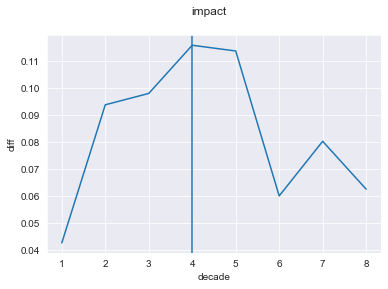

In [134]:
plot_change_point('impact')

change point at decade 3


<AxesSubplot:xlabel='decade', ylabel='diff'>

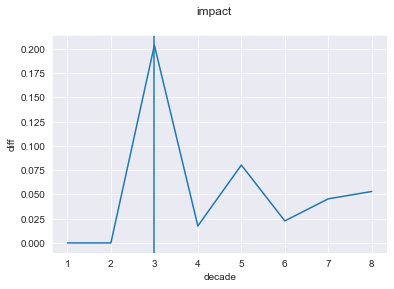

In [135]:
plot_change_point('techniques')

change point at decade 5


<AxesSubplot:xlabel='decade', ylabel='diff'>

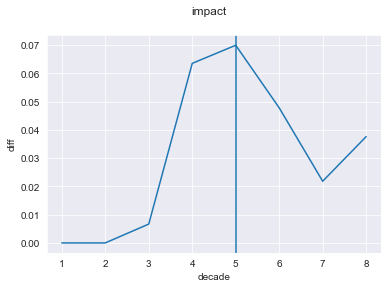

In [136]:
plot_change_point('skills')